# Presentation
---

Le but de cet exercice est de nous familiariser avec la manipulation de données. Pour ce faire, nous allons commencer par analyser une base de données de critiques tripadvisor pour ensuite faire de la prédiction de notes données par les clients. Le jeu de données peut être récupéré à [l'adresse suivante.](https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews/data).

## Import des librairies

In [46]:
from collections import Counter
from langdetect import detect
import matplotlib.pyplot as plt
import nltk
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
import plotly.express as px
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from transformers import pipeline
from wordcloud import WordCloud, STOPWORDS

In [ ]:
# Download nltk components
nltk.download("punkt")
nltk.download('stopwords')

pipe = pipeline("text-classification", model="nlptown/bert-base-multilingual-uncased-sentiment")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ClémentLION\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ClémentLION\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Chargement des données

In [7]:
tripadvisor_reviews = pd.read_csv("data/tripadvisor_hotel_reviews.csv")

# Partie 1) Etude de la qualité des données

---

1) De combien de données disposons-nous ? 
2) Possédons-nous des données manquantes ou des doublons ? 
3) Est-ce nous possédons des commentaires en doubles ? Qu'en faire ?
3) Quelles sont les longueurs de nos commentaires ?
3) Dans quelles langues se trouvent nos données ?

In [8]:
print(f"Le nombre de reviews est de {len(tripadvisor_reviews)}. Je possède {len(tripadvisor_reviews.columns)} colonnes.") 

Le nombre de reviews est de 20491. Je possède 2 colonnes.


In [9]:
tripadvisor_reviews.isna().sum()

Review    0
Rating    0
dtype: int64

In [10]:
tripadvisor_reviews.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [11]:
print(f"Est-ce que tous mes commentaires sont uniques ? {len(tripadvisor_reviews['Review'].apply(lambda x : x.lower()).unique()) == len(tripadvisor_reviews)}.")

Est-ce que tous mes commentaires sont uniques ? True.


In [12]:
tripadvisor_reviews["Review_len"] = tripadvisor_reviews["Review"].apply(len)

In [13]:
tripadvisor_reviews.describe()

,Rating,Review_len
count,20491.000000,20491.000000
mean,3.952223,724.896833
std,1.233030,689.101024
min,1.000000,44.000000
25%,3.000000,339.000000
50%,4.000000,537.000000
75%,5.000000,859.000000
max,5.000000,13501.000000


In [14]:
fig = px.histogram(tripadvisor_reviews.loc[tripadvisor_reviews["Review_len"] < 4000], x="Review_len", title = "Répartition des longueurs de textes")
fig.show()

In [20]:
tripadvisor_reviews["review_language"] = tripadvisor_reviews["Review"].apply(detect)

In [15]:
tripadvisor_reviews.groupby("review_language")["Review"].count()

KeyError: 'review_language'

In [22]:
tripadvisor_reviews.loc[tripadvisor_reviews["review_language"] != "en"]

,Review,Rating,Review_len,review_language
140,"rudest people dont stay, despite fact cool hot...",1,160,fr
1642,"good value good value money, suggest getting r...",4,92,af
4469,little gem lovely little hotel roman artifacts...,5,118,fr
4878,best hotels london nice small hotel suite not ...,5,104,fr
5189,best time best time hotel staff sexy helpful m...,5,134,nl
6851,excellence excellent just retruned delightful ...,5,165,fr
7643,"amazing weekend going make annual trip nyc, ho...",5,217,af
7925,"great beds, best beds hotel, friendly staff fr...",5,93,da
8043,"attitude love space receptionist rude abrupt, ...",2,75,ro
8205,"not good aware not 4 star hotel, stayed week d...",2,106,af


In [16]:
tripadvisor_reviews_en = tripadvisor_reviews.drop(index = [17264, 18859])

# Partie 2) Analyse

---

1) Analysez la distribution des notes. Qu'est-ce que cela présage pour la partie machine learning ?
2) Faire un wordcloud pour indiquer les mots les plus populaires dans nos différents commentaires en fonction de la note attribuée à la fin.
3) Faire la même chose que la question précédente mais avec du stemming au préalable (nous vous conseillons d'utiliser porterstemmer pour plus de facilité).
4) Faire la même chose que la question précédente mais cette fois-ci en considérant les groupes de deux mots adjacents (note culturelle : les groupes de k mots adjacents sont appelés k-grams)
5) Nous décidons qu'il serait bien de connaître un poil mieux nos utilisateurs. Afin de pouvoir en savoir plus, utilisons de la LDA afin de pouvoir trouver des thèmes dans nos commentaires d'utilisateurs. 

Note : afin d'étudier plus en détail les thèmes, nous aurions pu utiliser du bertopic qui nous aurait renvoyé des thèmes pertinents.

In [17]:
fig = px.histogram(tripadvisor_reviews_en, x = "Rating", title="Répartition des notes d'hôtels")
fig.show()

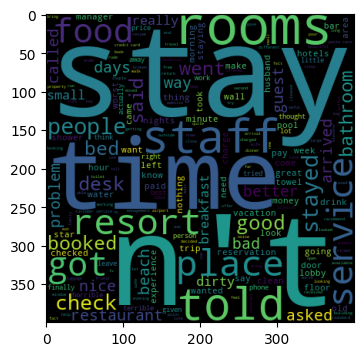

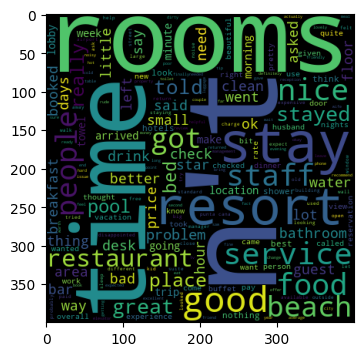

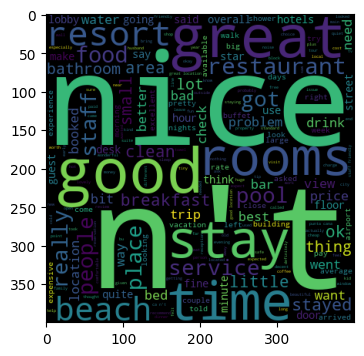

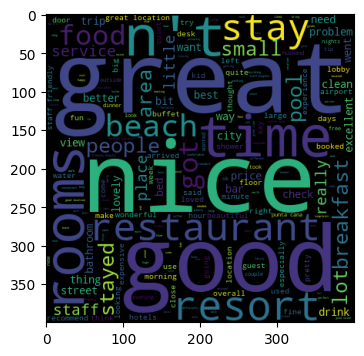

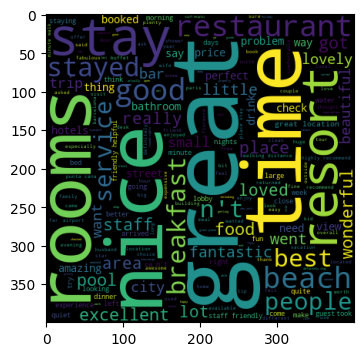

In [24]:
stop_words = set(list(set(STOPWORDS)) + ["hotel", "room", "day", 'night'])

for i in range(1,6):
    test_df = tripadvisor_reviews_en.loc[tripadvisor_reviews_en["Rating"] == i]
    review_test = " ".join(test_df["Review"].apply(lambda x : x.lower()).values)
    wordcloud = WordCloud(width=400, height=400, stopwords=stop_words).generate(review_test)
    plt.figure(figsize=(4,4))
    plt.imshow(wordcloud)
    plt.show()

In [25]:
tripadvisor_reviews_en["review_tokenized"] = tripadvisor_reviews_en["Review"].apply(word_tokenize)

In [29]:
ps = PorterStemmer()

In [30]:
tripadvisor_reviews_en["stemmed_text"] = tripadvisor_reviews_en["review_tokenized"].apply(lambda x : " ".join([ps.stem(word.lower()) for word in x if len(word) < 100]))

In [31]:
tripadvisor_reviews_en["stemmed_text"].iloc[0]

'nice hotel expens park got good deal stay hotel anniversari , arriv late even took advic previou review did valet park , check quick easi , littl disappoint non-exist view room room clean nice size , bed comfort woke stiff neck high pillow , not soundproof like heard music room night morn loud bang door open close hear peopl talk hallway , mayb just noisi neighbor , aveda bath product nice , did not goldfish stay nice touch taken advantag stay longer , locat great walk distanc shop , overal nice experi have pay 40 park night ,'

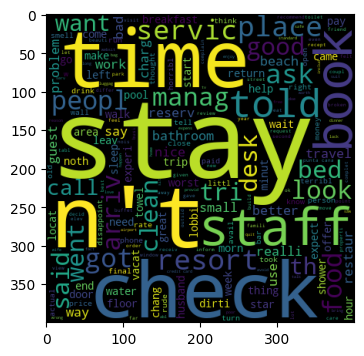

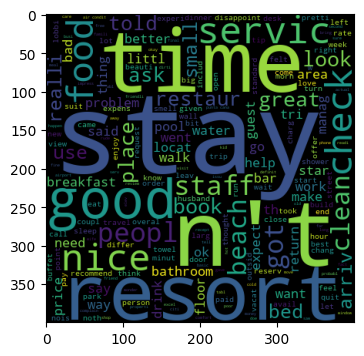

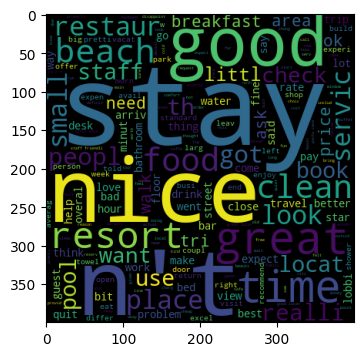

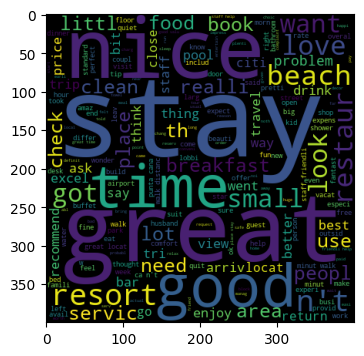

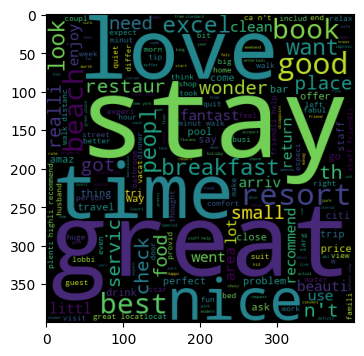

In [32]:
stop_words = set(list(set(STOPWORDS)) + ["hotel", "room", "day", 'night'])

for i in range(1,6):
    test_df = tripadvisor_reviews_en.loc[tripadvisor_reviews_en["Rating"] == i]
    review_test = " ".join(test_df["stemmed_text"].apply(lambda x : x.lower()).values)
    wordcloud = WordCloud(width=400, height=400, stopwords=stop_words).generate(review_test)
    plt.figure(figsize=(4,4))
    plt.imshow(wordcloud)
    plt.show()

In [43]:
# Question 5

cv = CountVectorizer(max_df=0.9, min_df=2)
base_de_mots = cv.fit_transform(tripadvisor_reviews_en["stemmed_text"])

lda = LatentDirichletAllocation(n_components = 7, random_state=42)

In [44]:
lda.fit(base_de_mots)

LatentDirichletAllocation(n_components=7, random_state=42)

In [45]:
for index, topics in enumerate(lda.components_):
    print(f"Thème : {index}")
    print([cv.get_feature_names_out()[i] for i in topics.argsort()[-5:]])

Thème : 0
['just', 'great', 'stay', 'staff', 'hotel']
Thème : 1
['not', 'good', 'stay', 'room', 'hotel']
Thème : 2
['not', 'pool', 'stay', 'room', 'hotel']
Thème : 3
['bu', 'park', 'day', 'cabl', 'car']
Thème : 4
['did', 'no', 'hotel', 'not', 'room']
Thème : 5
['staff', 'great', 'room', 'stay', 'hotel']
Thème : 6
['good', 'food', 'not', 'beach', 'resort']


# Partie 3) Machine learning

---

1) Faut-il considérer le problème comme un problème de classification ou de regression ? Discutez des enjeux des deux approches.
2) Comment transformer nos données textuelles afin de faire du deep learning ?
3) Utilisez un modèle pré-entrainé pour obtenir le sentiment de chaque texte.
4) Faire un embedding des textes en utilisant un modèle pré-entrainé.
5) Construisez un modèle de deep learning pour prédire les notes.

### Partie 4) Analyse de thèmes
---

1) En utilisant la méthode KMeans trouvez le nombre optimal de cluster dans nos données.
2) Identifiez les thèmes évoqués dans les différents clusters.
2) En utilisant BertTopic, classifiez nos avis par sujets.